In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.special import erf

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "text.latex.preamble": r"\usepackage{amsmath}"   })

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",""
#    "font.serif": ["Computer Modern Roman"],
#    "font.size": 12
#})

# color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

colors = [
    "#f94144", "#f3722c", "#f8961e", "#f9c74f", "#90be6d", 
    "#43aa8b", "#577590", "#277da1", "#4d908e", "#f9844a", 
    "#f4a261", "#e76f51", "#a8dadc", "#457b9d", "#1d3557", 
    "#ffcad4", "#bde0fe", "#a2d2ff", "#ffafcc", "#ffc8dd"
]

In [71]:
kappa1= np.sqrt(2.0 / np.pi)            
kappa_star = np.sqrt(1.0 - 2.0 / np.pi)     

tiny = 1e-20
huge = 1e+8

In [72]:
def update_hat_quantities(V_s, q_s, m_s,
                          V_w, q_w,
                          alpha, epsilon,
                          gamma):
    denom = 1.0 + kappa1 ** 2 * V_s + kappa_star ** 2 * V_w  +tiny  #da overflow se tolgo tiny

    hat_V_s = (kappa1 ** 2 / gamma) * alpha / denom

    common_numerator = 1 + kappa1 ** 2 * q_s + kappa_star ** 2 * q_w
    common_offset = 2 * kappa1 * m_s * np.sqrt(2 / np.pi)

    hat_q_s = (kappa1 ** 2 / gamma) * (
        alpha * epsilon * common_numerator /denom ** 2+
        alpha * (1 - epsilon) * (common_numerator - common_offset) / denom ** 2 
    )

    hat_m_s = (kappa1 / gamma) * alpha * (1 - epsilon) * np.sqrt(2 / np.pi) / denom

    hat_V_w = kappa_star ** 2 * alpha / denom

    hat_q_w = kappa_star ** 2 * (
        alpha * epsilon * common_numerator / denom ** 2 +
        alpha * (1 - epsilon) * (common_numerator - common_offset) / denom ** 2
    )

    return hat_V_s, hat_q_s, hat_m_s, hat_V_w, hat_q_w

In [73]:
def update_primal_quantities(hat_V_s, hat_q_s, hat_m_s,
                             hat_V_w, hat_q_w,
                             gamma, lam):

    z = (lam + hat_V_w) / hat_V_s
    sqrt_term = np.sqrt((1 + gamma + z) ** 2 - 4 * gamma)

    V_s_new = (z + 1 + gamma - sqrt_term) / (2 * gamma * hat_V_s)

    num_qs =( (hat_m_s ** 2 + hat_q_s)/ hat_V_s **2 ) * ((2 * z + gamma + 1) * sqrt_term - 2 * z ** 2 - 3 * (gamma + 1) * z - (gamma - 1) ** 2)
    num_qs -= hat_q_w /( (lam + hat_V_w) * hat_V_s )* (z * sqrt_term - z ** 2 - (gamma + 1) * z)
    den_qs = 2 * gamma * sqrt_term 
    q_s_new = num_qs / den_qs

    m_s_new = hat_m_s / hat_V_s * (z + 1 + gamma - sqrt_term) / (2 * gamma)

    V_w_new = (1 - gamma - z + sqrt_term) / (2 * (lam + hat_V_w))

    num_qw = hat_q_w / (lam + hat_V_w) ** 2 * ((1 - gamma) * sqrt_term + (gamma + 1) * z + (gamma - 1) ** 2)
    num_qw -= (hat_m_s ** 2 + hat_q_s) / ((lam + hat_V_w) * hat_V_s) * (z * sqrt_term - z ** 2 - (gamma + 1) * z)
    den_qw = 2 * sqrt_term
    q_w_new = num_qw / den_qw

    return V_s_new, q_s_new, m_s_new, V_w_new, q_w_new

In [93]:
def solve_state_equations(lam, alpha, gamma, epsilon,
                          max_iter = 50000, tol = 1e-5, damping = 0.2,
                          V_init = 3.0, q_init = 0.1, m_init = 0.1,
                          verbose = False):


    V_s, q_s, m_s = V_init, q_init, m_init
    V_w, q_w = V_init, q_init

    for it in range(max_iter):
        hat_V_s, hat_q_s, hat_m_s, hat_V_w, hat_q_w = update_hat_quantities(
            V_s, q_s, m_s, V_w, q_w, alpha, epsilon, gamma
        )

        Vs_new, qs_new, ms_new, Vw_new, qw_new = update_primal_quantities(
            hat_V_s, hat_q_s, hat_m_s, hat_V_w, hat_q_w, gamma, lam
        )

        V_s_next = damping * Vs_new + (1 - damping) * V_s
        q_s_next = damping * qs_new + (1 - damping) * q_s
        m_s_next = damping * ms_new + (1 - damping) * m_s
        V_w_next = damping * Vw_new + (1 - damping) * V_w
        q_w_next = damping * qw_new + (1 - damping) * q_w

        delta = max(abs(V_s_next - V_s), abs(q_s_next - q_s), abs(m_s_next - m_s),
                    abs(V_w_next - V_w), abs(q_w_next - q_w))

        if verbose:
            print(f"lam={lam:.2e} alpha={alpha:.2e} gamma={gamma:.2f} eps={epsilon:.2f}  "
                  f"it={it:4d} delta={delta:.3e}  V_s={V_s_next:.3e} q_s={q_s_next:.3e} "
                  f"m_s={m_s_next:.3e} V_w={V_w_next:.3e} q_w={q_w_next:.3e}")

        if delta < tol:
            break

        V_s, q_s, m_s, V_w, q_w = V_s_next, q_s_next, m_s_next, V_w_next, q_w_next

    return dict(V_s=V_s_next, q_s=q_s_next, m_s=m_s_next, V_w=V_w_next, q_w=q_w_next)


In [94]:
def compute_errors(sol: dict):
    Q_star = kappa1 ** 2 * sol['q_s'] + kappa_star ** 2 * sol['q_w']
    V_star = kappa1 ** 2 * sol['V_s'] + kappa_star ** 2 * sol['V_w']
    M_star = kappa1 * sol['m_s']

    # ratio = np.clip(M_star / np.sqrt(max(Q_star, 1e-32)), -1.0, 1.0)
    ratio = M_star / np.sqrt(max(Q_star, 1e-32))

    eps_mem = 0.5 * (1.0 - erf(V_star / np.sqrt(2.0 * max(Q_star, 1e-32))))
    eps_gen = np.arccos(ratio) / np.pi
    return eps_mem, eps_gen




In [95]:
def sweep_parameters(lam_list, gamma_list, alpha_list, eps_list,
                     max_iter = 50000, tol = 1e-5, damping = 0.2,
                     V_init = 3.0, q_init = 0.1, m_init = 0.1,
                     verbose = False):
    rows = []
    for lam, gamma, alpha, eps in product(lam_list, gamma_list, alpha_list, eps_list):
        sol = solve_state_equations(lam, alpha, gamma, eps,
                                    max_iter=max_iter, tol=tol, damping=damping,
                                    V_init=V_init, q_init=q_init, m_init=m_init,
                                    verbose=verbose)
        mem_err, gen_err = compute_errors(sol)
        rows.append(dict(lam=lam, gamma=gamma, alpha=alpha, eps=eps,
                         mem_err=mem_err, gen_err=gen_err, **sol))
    return pd.DataFrame(rows)

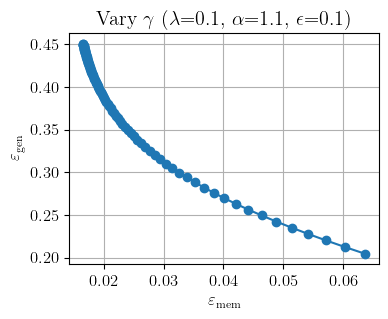

In [96]:
#change gamma

lambda_fix, alpha_fix, epsilon_fix = 1e-1, 1.1, 0.10
gamma_grid = np.linspace(0.01, 2.00, 100)

mem, gen = [], []
for gamma in gamma_grid:
    sol = solve_state_equations(lambda_fix, alpha_fix, gamma, epsilon_fix,
                                max_iter=50000, damping=0.2)
    m, g = compute_errors(sol)
    mem.append(m);  gen.append(g)

plt.figure(figsize=(4, 3))
plt.plot(mem, gen, marker='o')
plt.xlabel(r"$\varepsilon_{\mathrm{mem}}$")
plt.ylabel(r"$\varepsilon_{\mathrm{gen}}$")
plt.title(fr"Vary $\gamma$  ($\lambda$={lambda_fix}, $\alpha$={alpha_fix}, $\epsilon$={epsilon_fix})")
plt.grid(True);  plt.show()

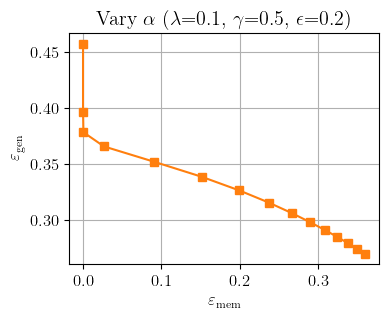

In [97]:
# change alpha

lambda_fix, gamma_fix, epsilon_fix = 1e-1, 0.50, 0.20
alpha_grid = np.linspace(0.05, 5.00, 15)

mem, gen = [], []
for alpha in alpha_grid:
    sol = solve_state_equations(lambda_fix, alpha, gamma_fix, epsilon_fix,
                                max_iter=50000, damping=0.2)
    m, g = compute_errors(sol)
    mem.append(m);  gen.append(g)

plt.figure(figsize=(4, 3))
plt.plot(mem, gen, marker='s', color='tab:orange')
plt.xlabel(r"$\varepsilon_{\mathrm{mem}}$")
plt.ylabel(r"$\varepsilon_{\mathrm{gen}}$")
plt.title(fr"Vary $\alpha$  ($\lambda$={lambda_fix}, $\gamma$={gamma_fix}, $\epsilon$={epsilon_fix})")
plt.grid(True);  plt.show()

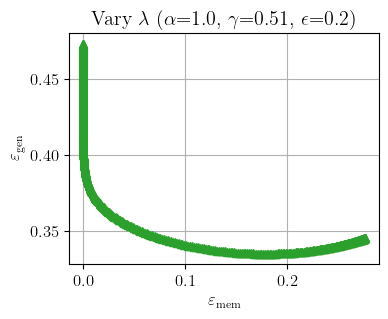

In [98]:
# vary lambda 

alpha_fix, gamma_fix, epsilon_fix = 1.0, 0.510, 0.20
lambda_grid = np.logspace(-4, 2, 500)       

mem, gen = [], []
for lam in lambda_grid:
    sol = solve_state_equations(lam, alpha_fix, gamma_fix, epsilon_fix,
                                max_iter=50000, damping=0.2)
    m, g = compute_errors(sol)
    mem.append(m);  gen.append(g)

plt.figure(figsize=(4, 3))
plt.plot(mem, gen, marker='^', color='tab:green')
plt.xscale('linear')                       
plt.xlabel(r"$\varepsilon_{\mathrm{mem}}$")
plt.ylabel(r"$\varepsilon_{\mathrm{gen}}$")
plt.title(fr"Vary $\lambda$  ($\alpha$={alpha_fix}, $\gamma$={gamma_fix}, $\epsilon$={epsilon_fix})")
plt.grid(True);  plt.show()

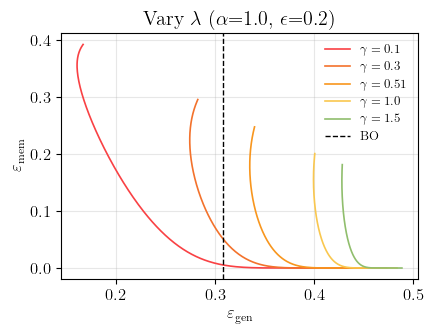

In [100]:
alpha_fix, epsilon_fix = 1.0, 0.20
gamma_list = [0.10, 0.30, 0.510, 1.00, 1.50]

lambda_grid = np.logspace(-4, 1, 500)     
sel_colors  = colors[:5]           

plt.figure(figsize=(4.5, 3.5))

for gamma, c in zip(gamma_list, sel_colors):
    mem, gen = [], []
    for lam in lambda_grid:
        sol = solve_state_equations(lam, alpha_fix, gamma, epsilon_fix,
                                    max_iter=50000, damping=0.2)
        m, g = compute_errors(sol)
        mem.append(m);  gen.append(g)

    plt.plot(gen, mem, lw=1.2, color=c, label=fr"$\gamma={gamma}$")

x_ref = (1/np.pi) * np.arccos(np.sqrt(0.32162913112768393))
plt.axvline(x_ref, color='k', ls='--', lw=1.0, label='BO')

plt.ylabel(r"$\varepsilon_{\mathrm{mem}}$")
plt.xlabel(r"$\varepsilon_{\mathrm{gen}}$")
plt.title(fr"Vary $\lambda$  ($\alpha$={alpha_fix}, $\epsilon$={epsilon_fix})")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig("RF.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [92]:
(1/np.pi) * np.arccos(np.sqrt(0.32162913112768393))

0.30805619244960847

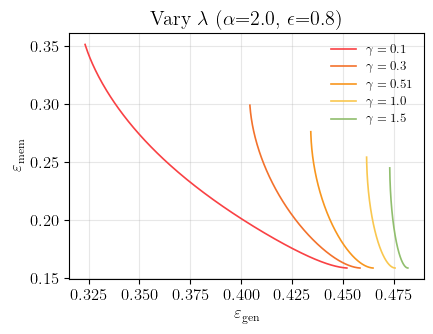

In [88]:
alpha_fix, epsilon_fix = 2.0, 0.80
gamma_list  = [0.10, 0.30, 0.510, 1.00, 1.50]

lambda_grid = np.logspace(-4, 1, 500)    
sel_colors  = colors[:5]                  

plt.figure(figsize=(4.5, 3.5))

for gamma, c in zip(gamma_list, sel_colors):
    mem, gen = [], []
    for lam in lambda_grid:
        sol = solve_state_equations(lam, alpha_fix, gamma, epsilon_fix,
                                    max_iter=50000, damping=0.2)
        m, g = compute_errors(sol)
        mem.append(m);  gen.append(g)

    plt.plot(gen, mem, lw=1.2, color=c, label=fr"$\gamma={gamma}$")

plt.xlabel(r"$\varepsilon_{\mathrm{gen}}$")
plt.ylabel(r"$\varepsilon_{\mathrm{mem}}$")
plt.title(fr"Vary $\lambda$  ($\alpha$={alpha_fix}, $\epsilon$={epsilon_fix})")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig("RF.pdf", bbox_inches="tight", dpi=300)
plt.show()

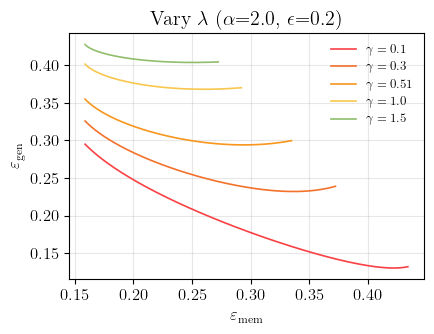

In [83]:
alpha_fix, epsilon_fix = 2.0, 0.20
gamma_list = [0.10, 0.30, 0.510, 1.00, 1.50]

lambda_grid = np.logspace(-4, 1, 500)     
sel_colors  = colors[:5]           

plt.figure(figsize=(4.5, 3.5))

for gamma, c in zip(gamma_list, sel_colors):
    mem, gen = [], []
    for lam in lambda_grid:
        sol = solve_state_equations(lam, alpha_fix, gamma, epsilon_fix,
                                    max_iter=50000, damping=0.2)
        m, g = compute_errors(sol)
        mem.append(m);  gen.append(g)

    plt.plot(mem, gen, lw=1.2, color=c, label=fr"$\gamma={gamma}$")

plt.xlabel(r"$\varepsilon_{\mathrm{mem}}$")
plt.ylabel(r"$\varepsilon_{\mathrm{gen}}$")
plt.title(fr"Vary $\lambda$  ($\alpha$={alpha_fix}, $\epsilon$={epsilon_fix})")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.tight_layout()
plt.show()

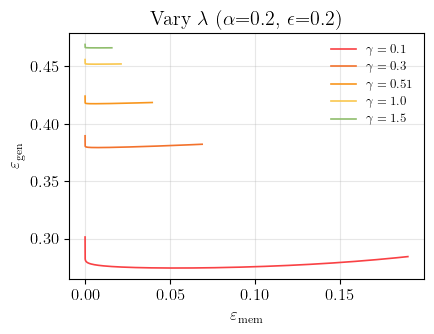

In [84]:
alpha_fix, epsilon_fix = 0.2, 0.20
gamma_list = [0.10, 0.30, 0.510, 1.00, 1.50]

lambda_grid = np.logspace(-4, 1, 500)     
sel_colors  = colors[:5]           

plt.figure(figsize=(4.5, 3.5))

for gamma, c in zip(gamma_list, sel_colors):
    mem, gen = [], []
    for lam in lambda_grid:
        sol = solve_state_equations(lam, alpha_fix, gamma, epsilon_fix,
                                    max_iter=50000, damping=0.2)
        m, g = compute_errors(sol)
        mem.append(m);  gen.append(g)

    plt.plot(mem, gen, lw=1.2, color=c, label=fr"$\gamma={gamma}$")

plt.xlabel(r"$\varepsilon_{\mathrm{mem}}$")
plt.ylabel(r"$\varepsilon_{\mathrm{gen}}$")
plt.title(fr"Vary $\lambda$  ($\alpha$={alpha_fix}, $\epsilon$={epsilon_fix})")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.tight_layout()
plt.show()